In [1]:
#Pre-requisition
#!python -m pip install keras
#!python -m pip install --upgrade tensorflow

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
sb.set()

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../../Data/AAPLTrain.csv",parse_dates=['Date'],index_col=['Date'])
test = pd.read_csv("../../Data/AAPLTest.csv",parse_dates=['Date'],index_col=['Date'])

# Data Preparation of LSTM

In order for the data to be fitted into LSTM, it requires certain transformation of a 2D array into 3D input.

First, a transformation of the data to be consolidated into the range of 0 to 1, where it is easier to estimate the price.

Afterwards, by consolidating the price into a months worth, it reduces the chances of false positive in fluctuation, allowing better learning within the network.

In [3]:
train = train.loc[lambda x : x.index > dt.datetime(2012,12,31)]
train = train.reset_index()['Adj Close']
scaler = MinMaxScaler(feature_range=(0,1))
df_train = scaler.fit_transform(np.array(train).reshape(-1,1))

In [4]:
n_steps = 30;

In [5]:
def create_dataset(dataset,time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [6]:
x_train, y_train = create_dataset(df_train,n_steps)

In [7]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)

# LSTM
Long Short-Term Memory is a type of recurrent neural network (**RNN**) used to learn long-term dependencies.
Within the network, working similarly to memory blocks that are connected through layers. It will throw away irrelevant information, retaining vital information through training. <br/>

## Stacked LSTM

A variant of LSTM, using multiple hidden LSTM layers stacked on top of one another, making it deeper recombining the learned representation from previous layers and create new representation at high levels of abstraction.

Eg of Stacked LSTM: Lines --> Shapes --> Objects

By adding layers within layers of LSTM, a more complex feature representation of current input will be created. By increasing the depth, it allows for a better understanding for the movement of the price.

In [8]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu',input_shape=(n_steps,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [9]:
history = model.fit(x_train,y_train, epochs=50,validation_data=(x_train,y_train),shuffle=False,verbose=False)

# Rolling Prediction

As the LSTM is able to forecast one prediction from the training dataset, the network can predict continuously by rolling forward the prediction. Thus, creating a rolling prediction estimating the price.

In [10]:
prediction_list = []
last_x = x_train[-1]
while len(prediction_list) < len(test):
    p = model.predict(last_x.reshape(1,n_steps,1))[0,0]

    prediction_list.append(p)
    last_x = np.roll(last_x,-1)
    last_x[-1] = p

prediction_list = scaler.inverse_transform(prediction_list)
test['Prediction'] = prediction_list

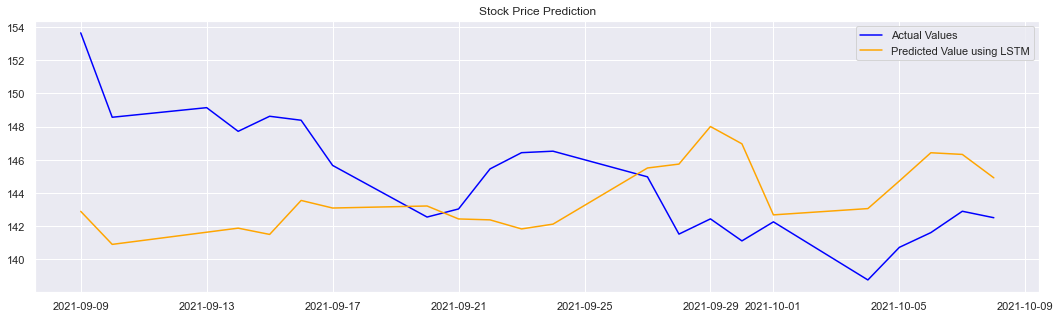

In [11]:
fig = plt.figure(figsize=(18,5))
plt.plot(test['Adj Close'], color="blue",label="Actual Values")
plt.plot(test['Prediction'], color="orange",label="Predicted Value using LSTM")
plt.title("Stock Price Prediction")
plt.legend()

# Prediction

Although the prediction is not 100% accurate, it is able to give a rough estimation certain range.
The approach that we have used maybe naive and not best suited, hence by combining with other tools, it can enhance the accuracy of the prediction.

# Further Reading on LSTM

To continue understanding the reason and application of LSTM, please continue on to the [documentation](../../Docs/algo_opt.md).

## Further Reading for multiple predictor

With the expansion and research upon LSTM, it is able to encompass multi-variate, allowing multiple predictor used to predict the stock price.

[Click here for further reading](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)